In [1]:
import tensorflow as tf
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
print(tf.version.VERSION)

2.1.0


In [2]:
DATADIR0 = r"D:\K14\Dataset\K14-Dataset-0-Multi-V1.pickle"
DATADIR1 = r"D:\K14\Dataset\K14-Dataset-0-Stuff.pickle"
DATADIR2 = os.path.dirname(r"C:\Users\8holz\Dokumente\GitHub\K14\Training_Protocol\\")
DATADIR3 = None

checkpoint_path = "C:/Users/8holz/Dokumente/GitHub/K14/Training_Protocol\Model-Grayscale-UNET/weights/saved_model.pb"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [3]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

In [4]:
Data = pickle.load(open(DATADIR0, "rb"))
X_train = Data["TrainImages0"]
Y_train = Data["TrainImages1"]

X_test = Data["TestImages0"]
Y_test = Data["TestImages1"]

In [5]:
# Define a simple sequential model
def create_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    #Build the model
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [5]:
model = create_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model.summary()

configproto = tf.compat.v1.ConfigProto() 
configproto.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=configproto) 
tf.compat.v1.keras.backend.set_session(sess)

472/472 - 9s - loss: 0.9894 - accuracy: 0.1493
Untrained model, accuracy: 14.93%


In [6]:
def load_K14():
    model = create_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    #model.summary()
    model = tf.keras.models.load_model(checkpoint_dir)

    configproto = tf.compat.v1.ConfigProto() 
    configproto.gpu_options.allow_growth = True
    sess = tf.compat.v1.Session(config=configproto) 
    tf.compat.v1.keras.backend.set_session(sess)
    return model

In [7]:
def Train_K14(model):
    ################################
    #Modelcheckpoint
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir, verbose=1, save_best_only=True)

    callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
            tf.keras.callbacks.TensorBoard(log_dir='logs')]

    results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=1, callbacks=[checkpointer])
    ####################################

In [8]:
for i in range(1):
    print("Epoch: "+str(i)+" is starting")
    model = load_K14()
    Train_K14(model)
    time.sleep(5)
    print("Epoch finished\n")
print("Training done so far\n")

Epoch: 0 is starting
Train on 1276 samples, validate on 142 samples
  16/1276 [..............................] - ETA: 17:49WARNING:tensorflow:Can save best model only with val_loss available, skipping.


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node model_2/conv2d_38/StatefulPartitionedCall/StatefulPartitionedCall/Conv2D}}]] [Op:__inference_distributed_function_11572]

Function call stack:
distributed_function


In [9]:
ls {checkpoint_dir}

 Volume in Laufwerk C: hat keine Bezeichnung.
 Volumeseriennummer: 0654-BAD9

 Verzeichnis von C:\Users\8holz\Dokumente\GitHub\K14\weights

06.12.2020  11:06    <DIR>          .
06.12.2020  11:06    <DIR>          ..
05.12.2020  22:41    <DIR>          assets
06.12.2020  11:06           869'867 saved_model.pb
06.12.2020  11:06    <DIR>          variables
               1 Datei(en),        869'867 Bytes
               4 Verzeichnis(se), 96'316'968'960 Bytes frei


472/472 [==============================] - 5s 10ms/sample


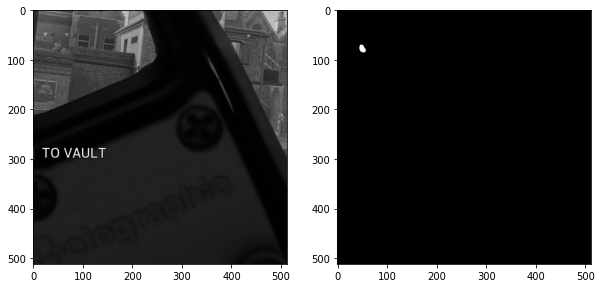

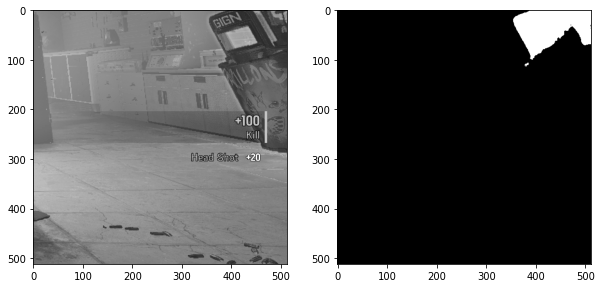

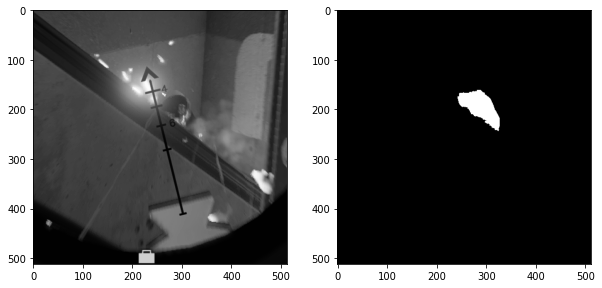

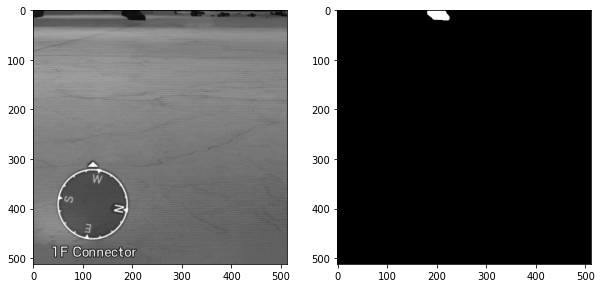

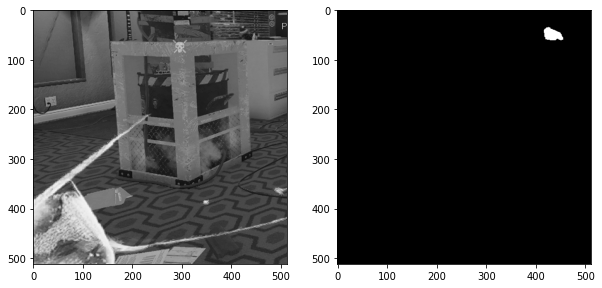

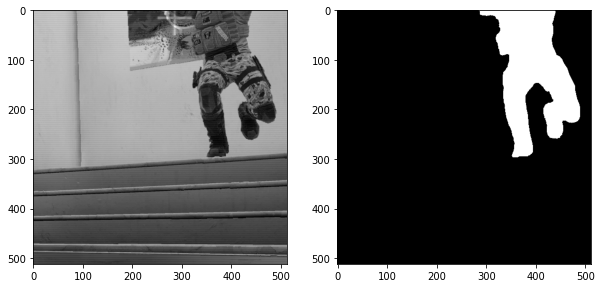

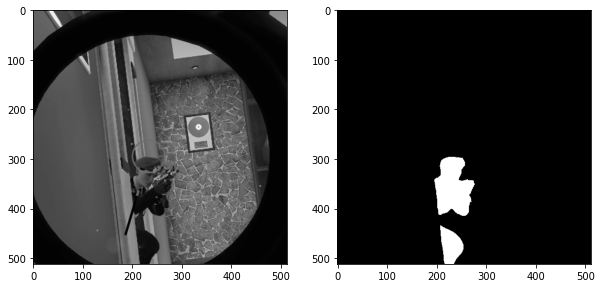

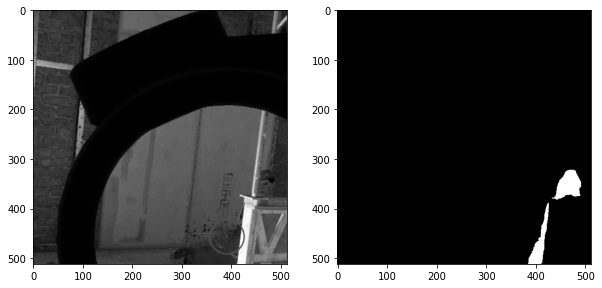

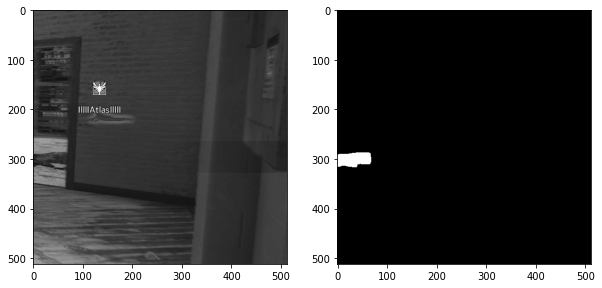

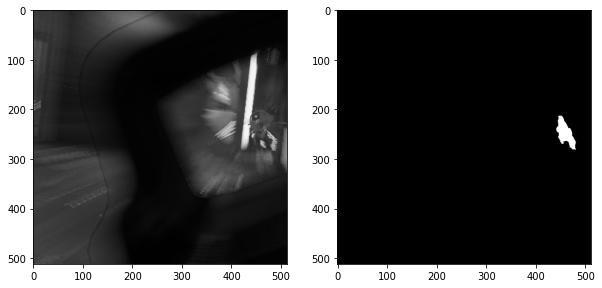

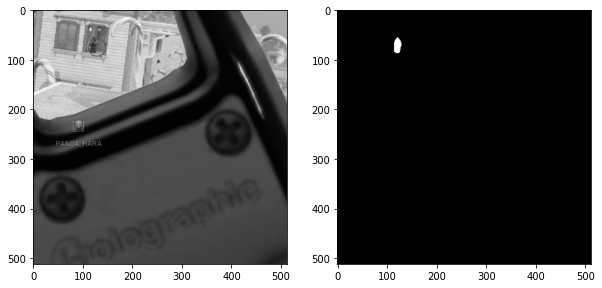

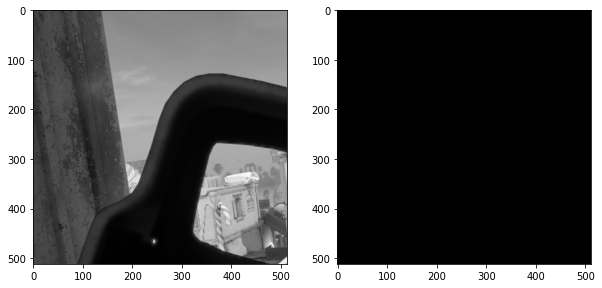

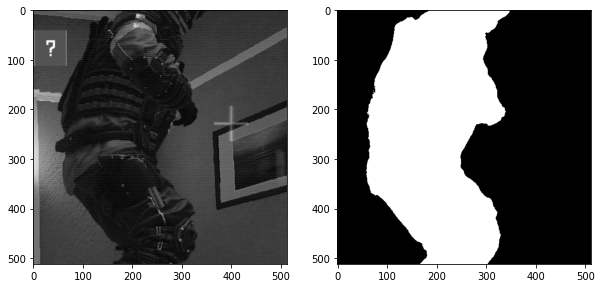

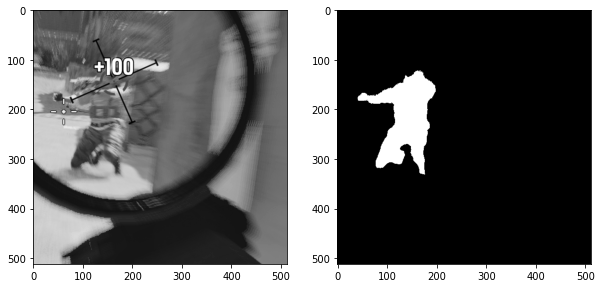

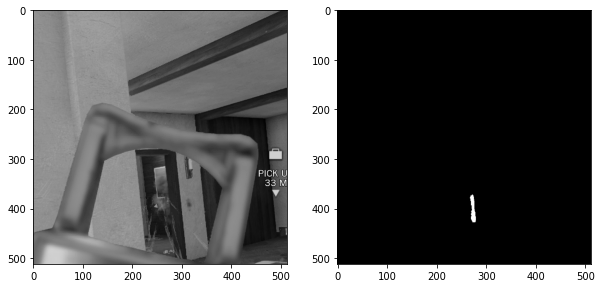

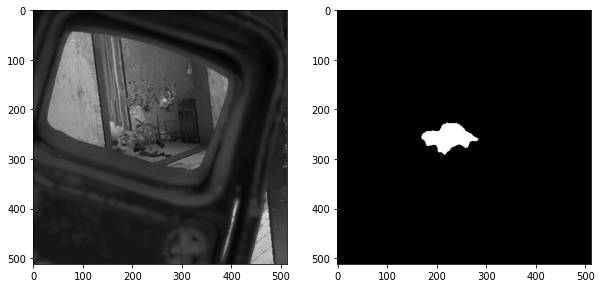

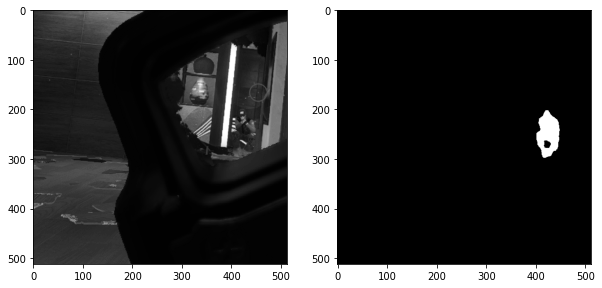

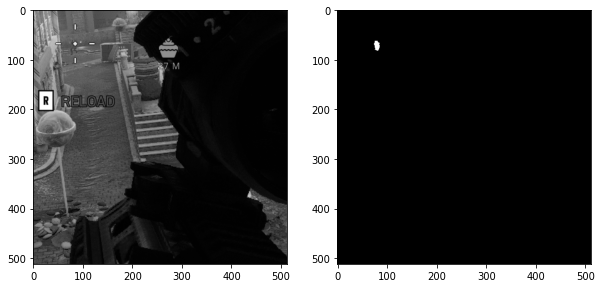

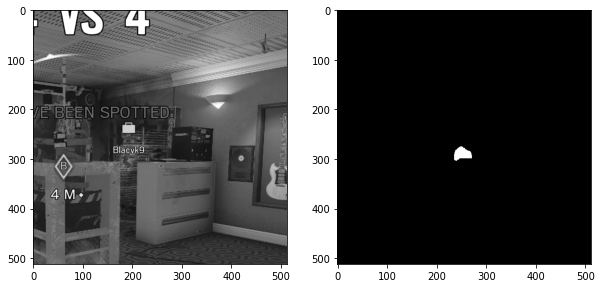

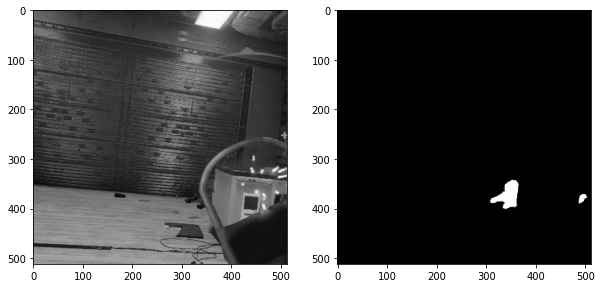

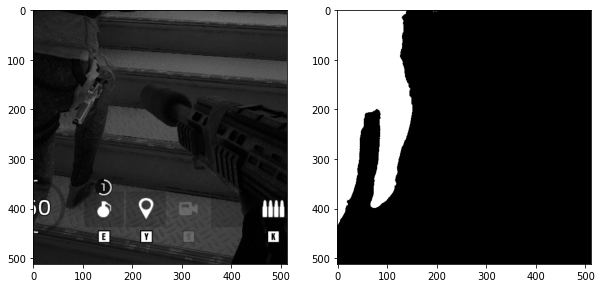

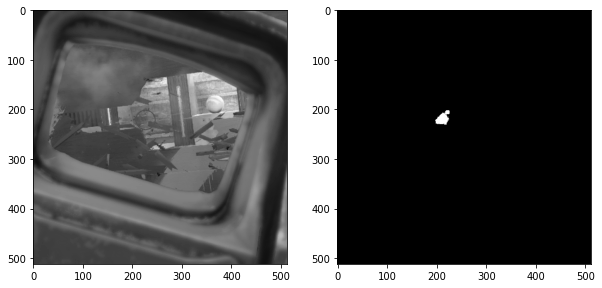

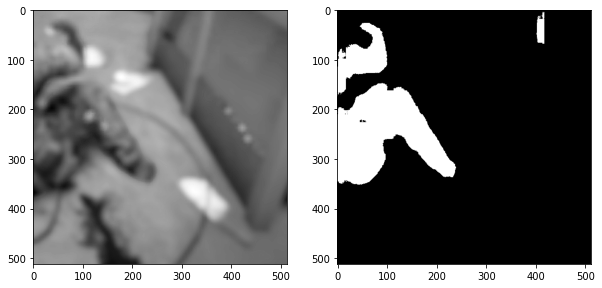

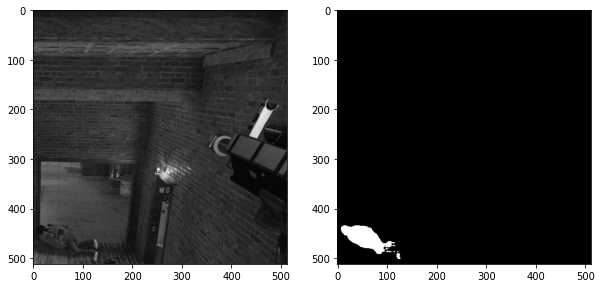

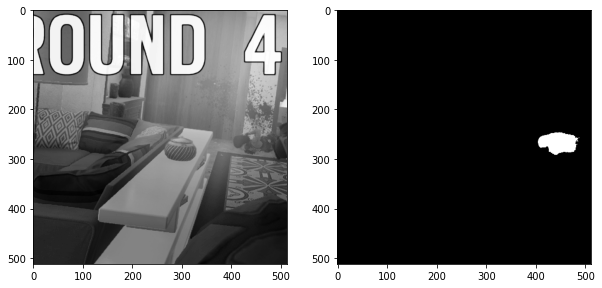

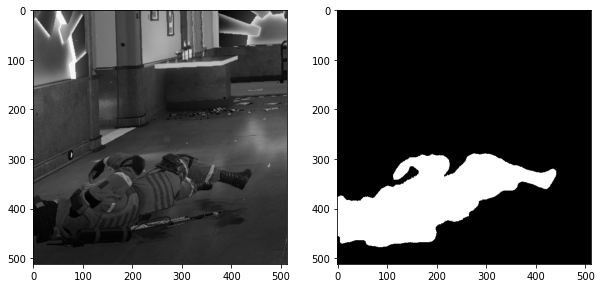

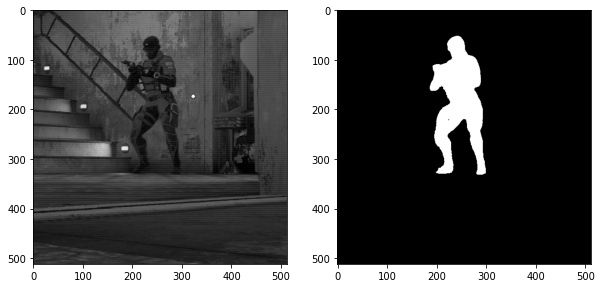

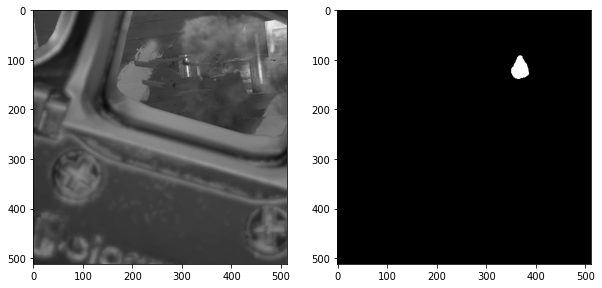

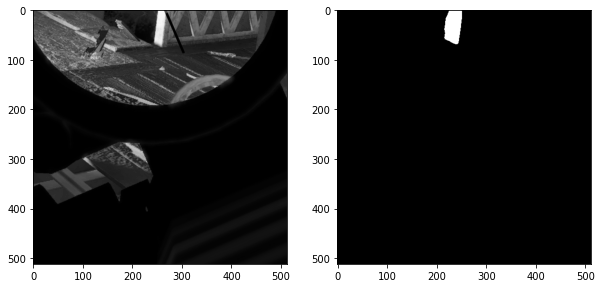

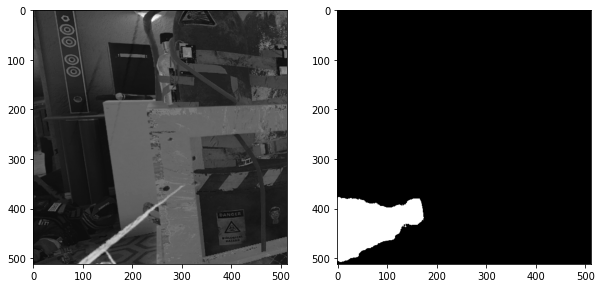

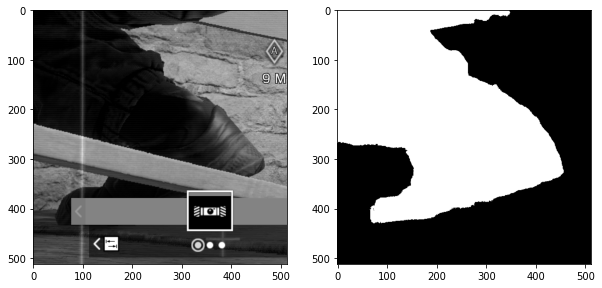

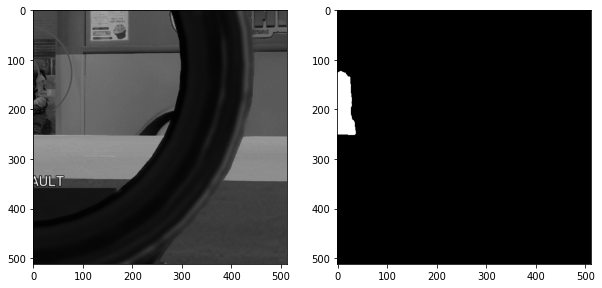

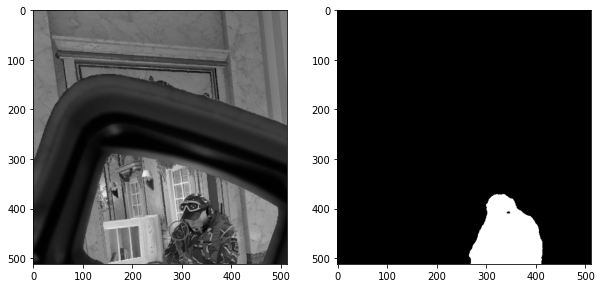

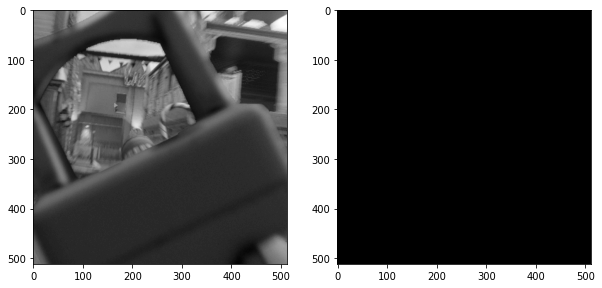

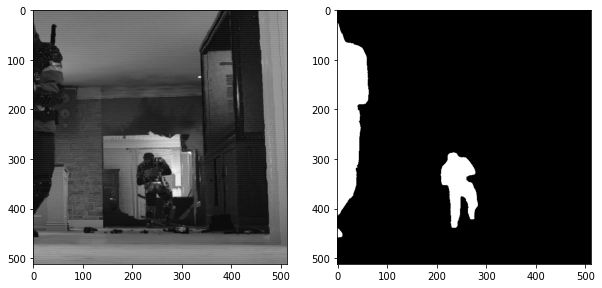

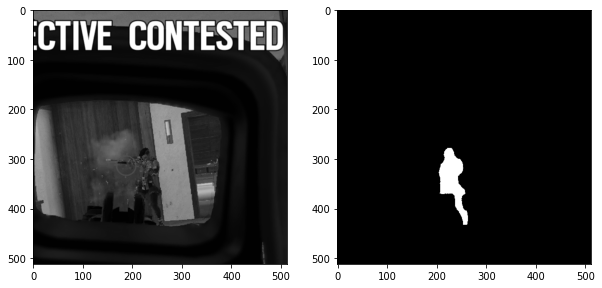

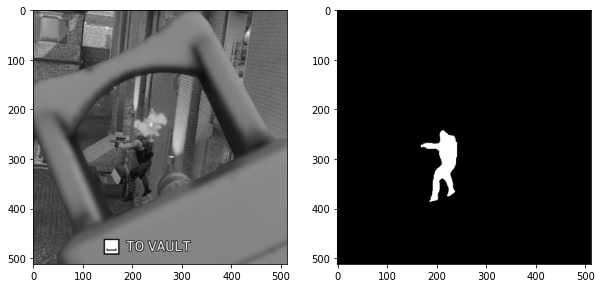

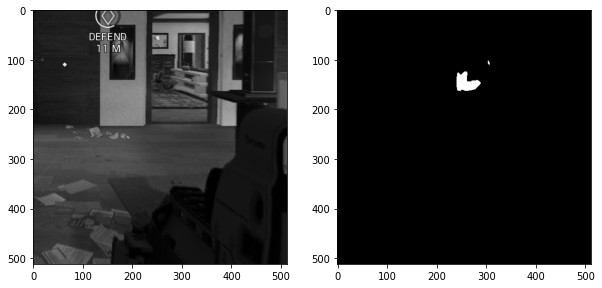

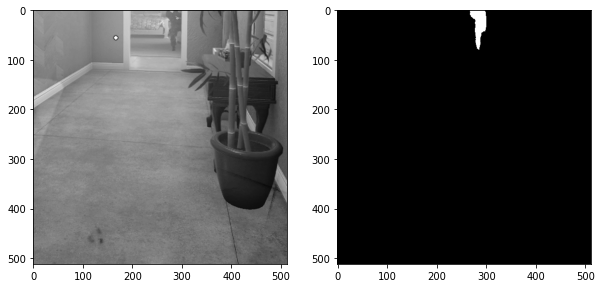

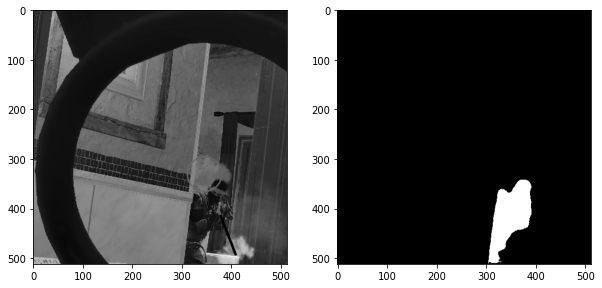

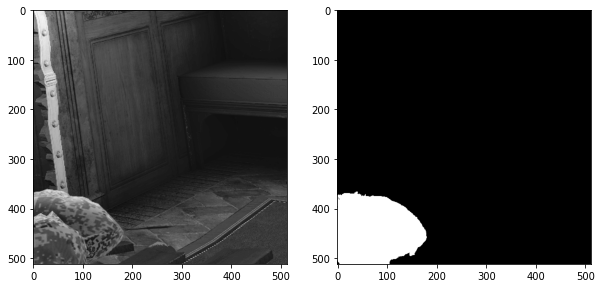

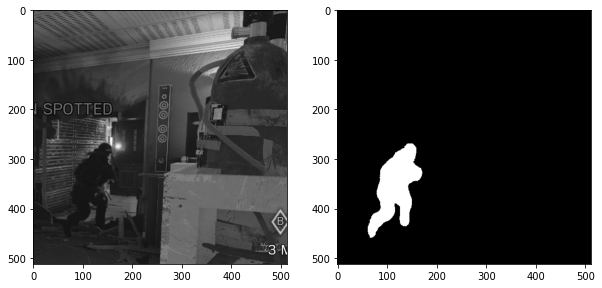

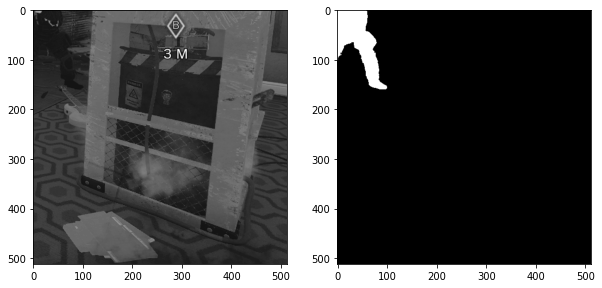

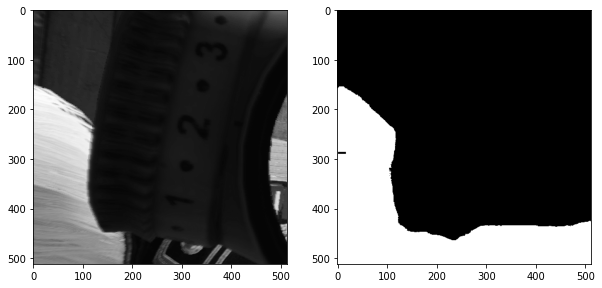

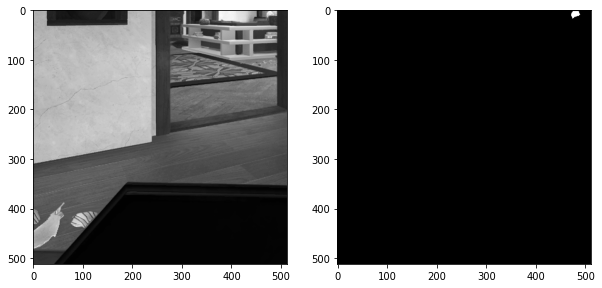

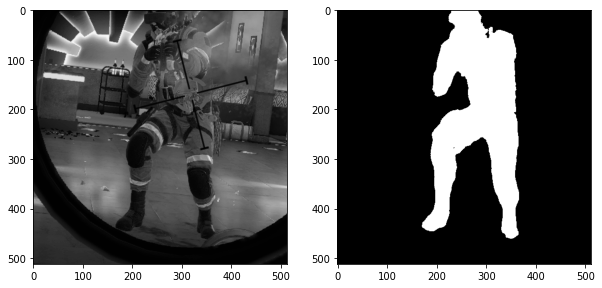

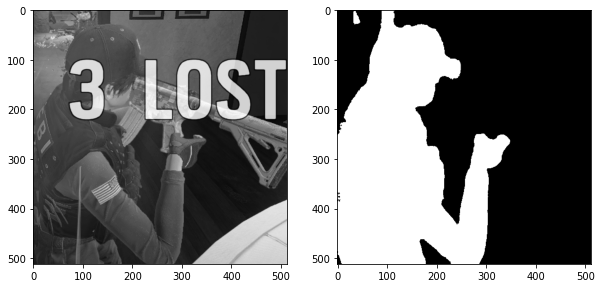

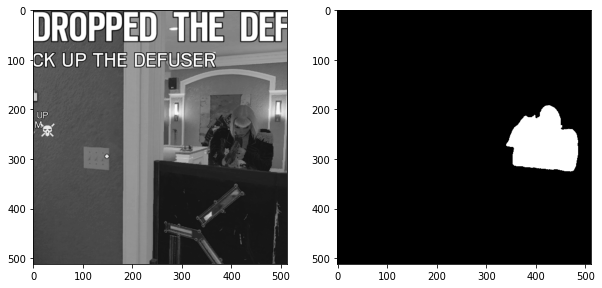

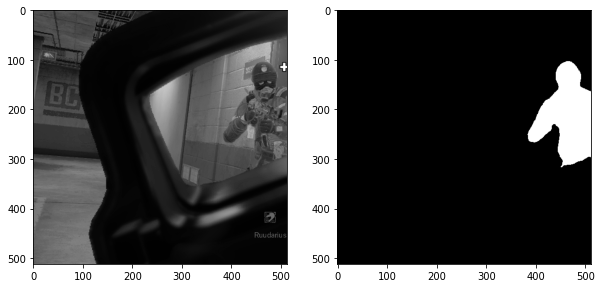

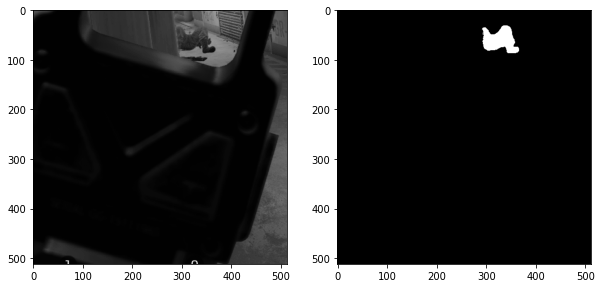

In [10]:
idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

"""
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
plt.imshow(X_train[ix])
plt.show()
plt.imshow(np.squeeze(Y_train[ix]))
plt.show()
plt.imshow(np.squeeze(preds_train_t[ix]))
plt.show()
"""

def ImCompareGray(Im1, Im2, FigSize=(10,10)):
    f = plt.figure(figsize=FigSize)
    f.add_subplot(1,2, 1)
    plt.imshow(Im1, cmap="gray")
    f.add_subplot(1,2, 2)
    plt.imshow(Im2, cmap="gray")
    plt.show(block=True)

for i in range(50):
	ImCompareGray(X_train[i], np.squeeze(preds_train_t[i]))

In [33]:
Dir = r"C:\Users\8holz\Dokumente\GitHub\K14\Training_Protocol\Model-Grayscale-UNET\images.pickle"
a = []
for i in X_train, Y_train, preds_train_t:
    a.append(i)
pickle.dump(a, open(Dir, "wb"))

In [32]:
"""
def Protocol(Dir, ModelName, Model, Img):
    #Model needs full path
    os.chdir(Dir)
    os.mkdir(ModelName)
    os.chdir(ModelName)
    os.system(" cp "+str(Model)+" "+str(Dir+ModelName+"Model.ckpt"))
"""

'\ndef Protocol(Dir, ModelName, Model, Img):\n    #Model needs full path\n    os.chdir(Dir)\n    os.mkdir(ModelName)\n    os.chdir(ModelName)\n    os.system(" cp "+str(Model)+" "+str(Dir+ModelName+"Model.ckpt"))\n'

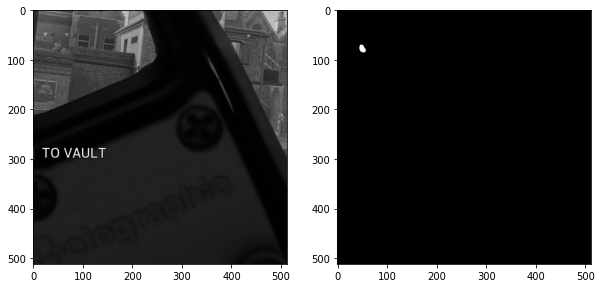

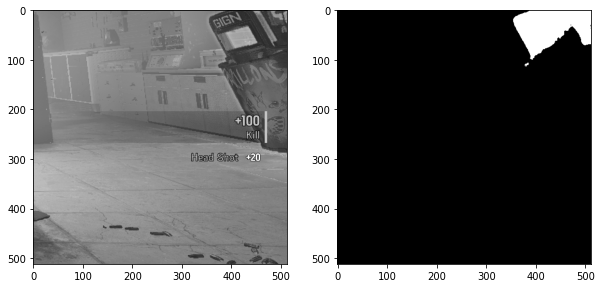

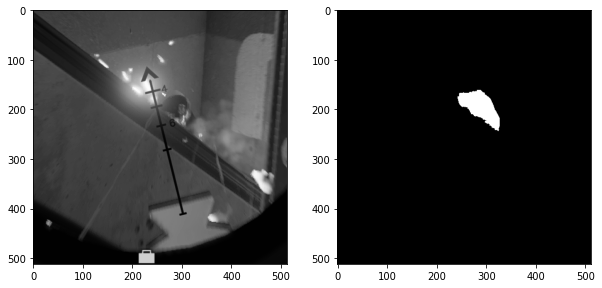

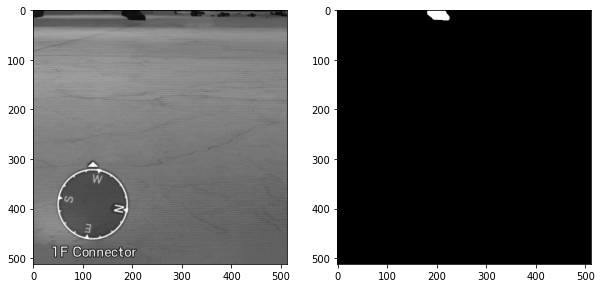

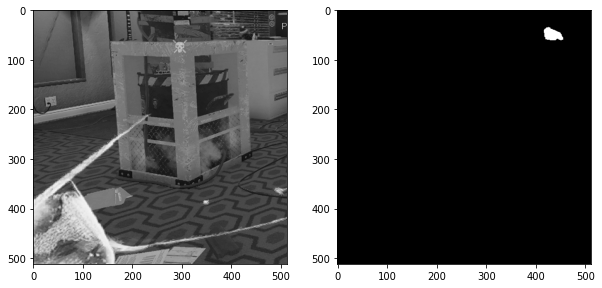

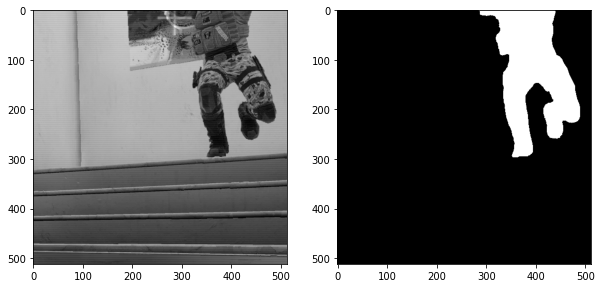

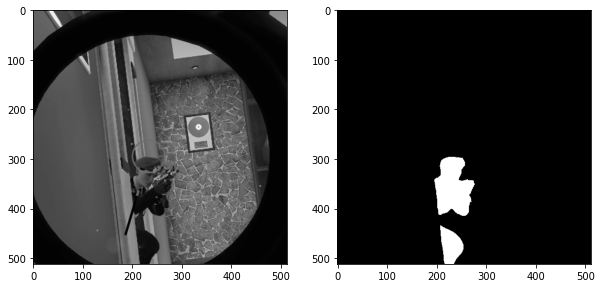

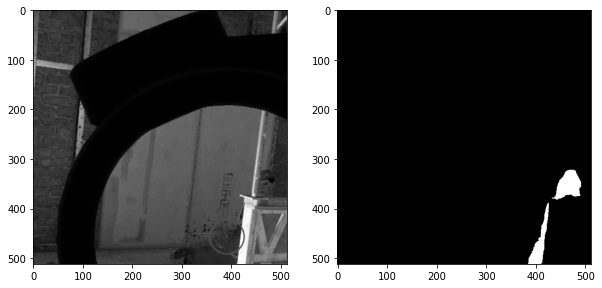

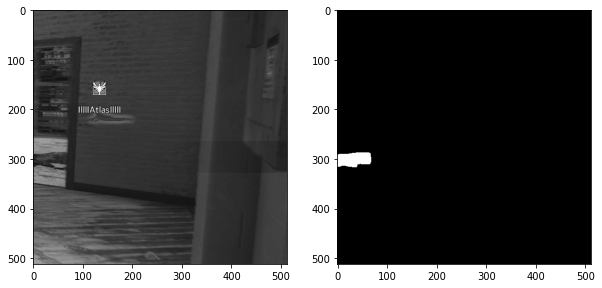

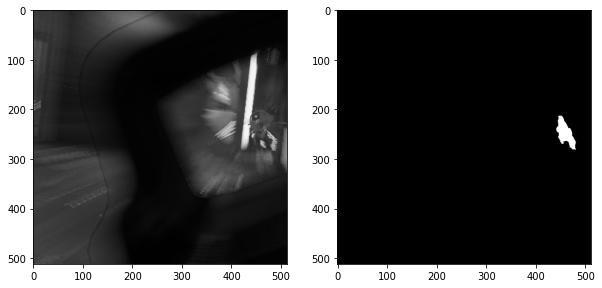

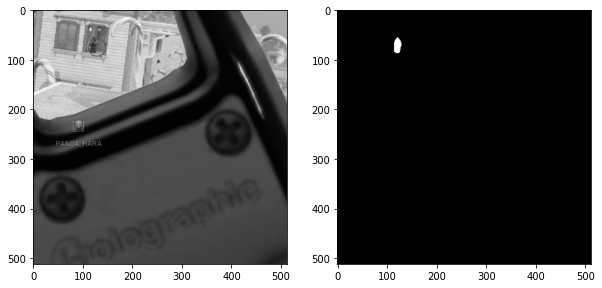

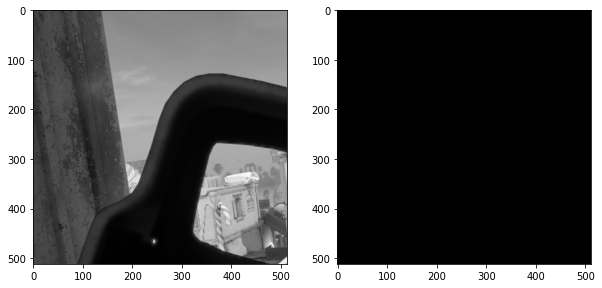

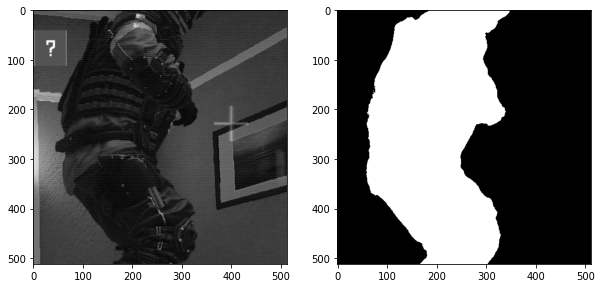

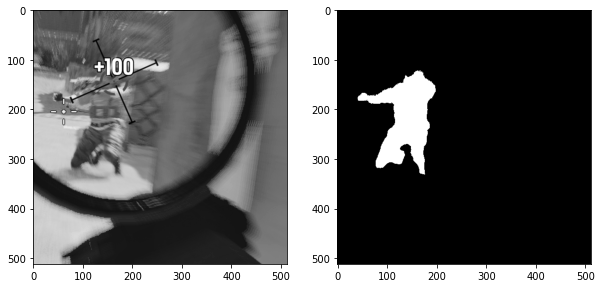

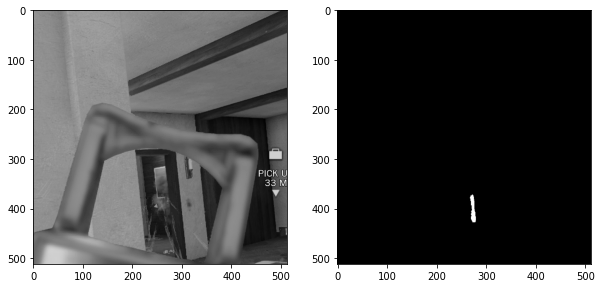

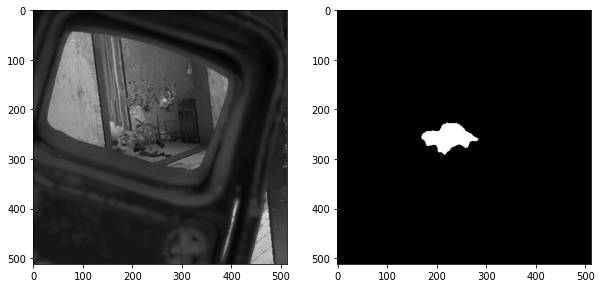

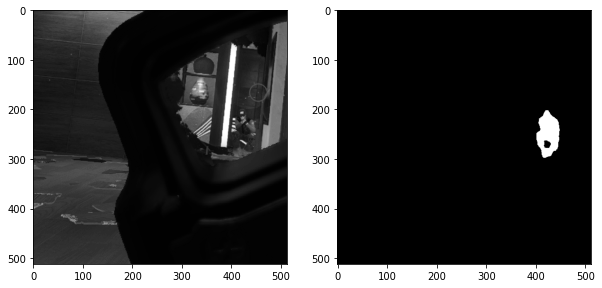

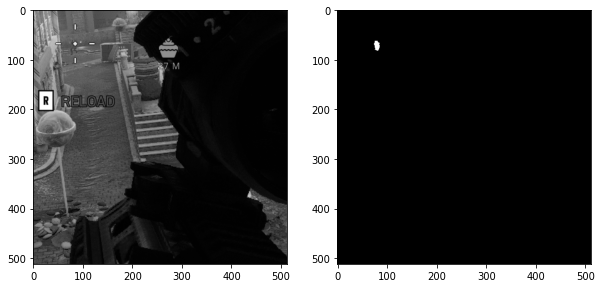

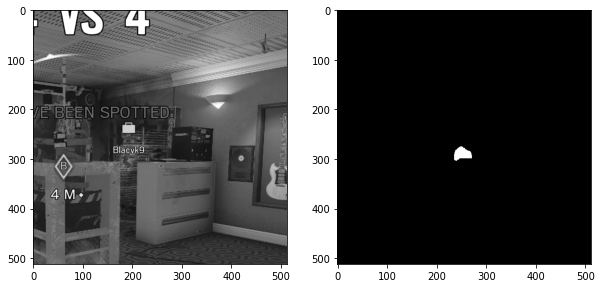

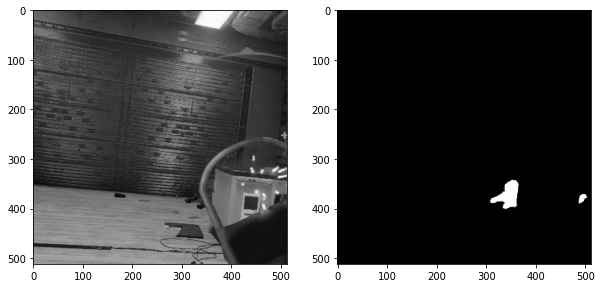

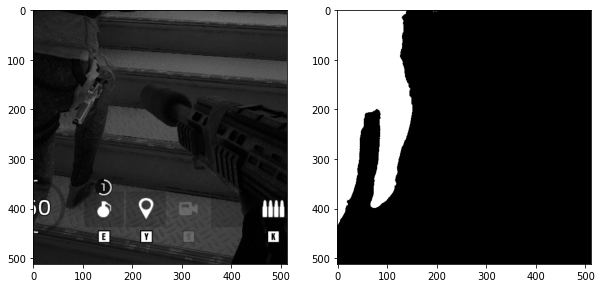

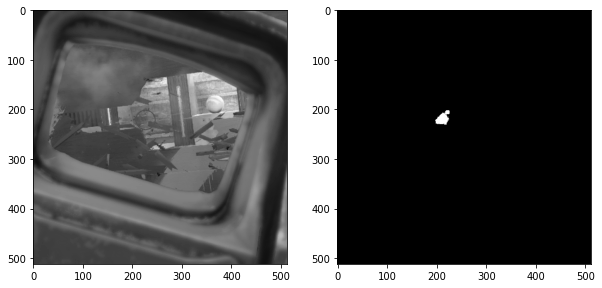

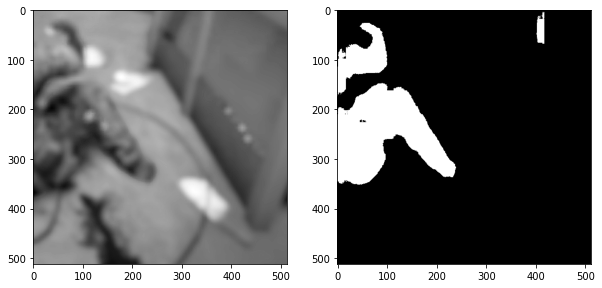

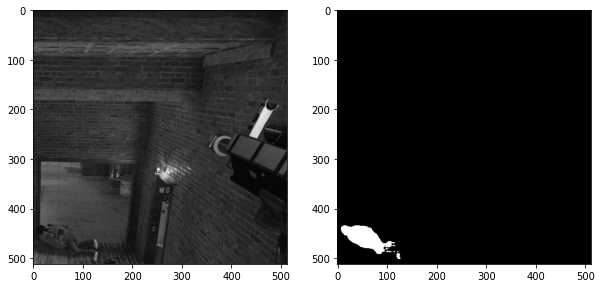

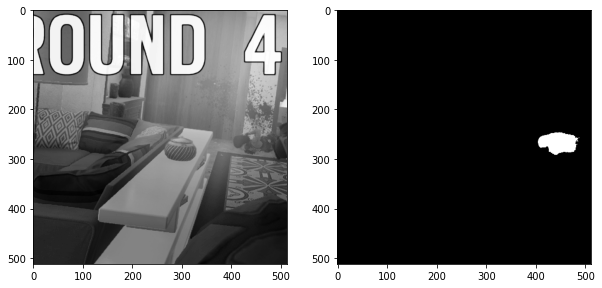

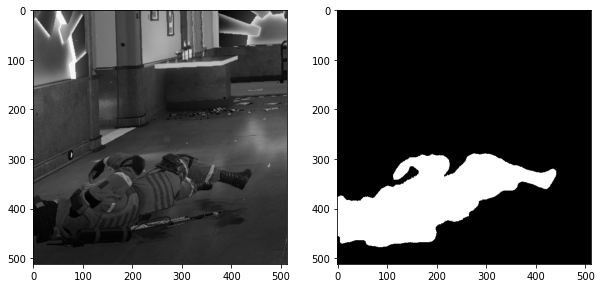

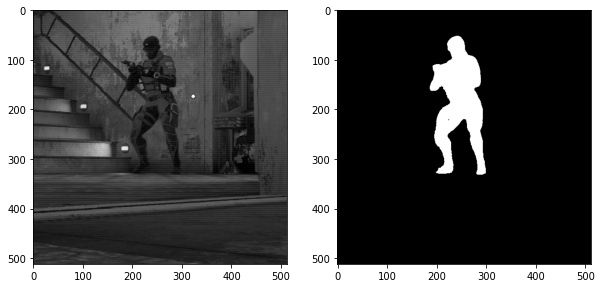

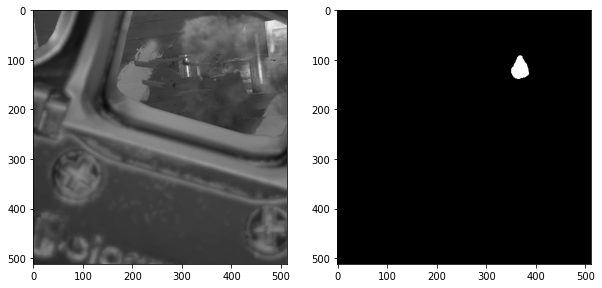

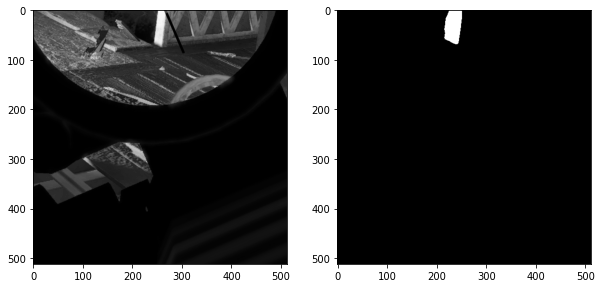

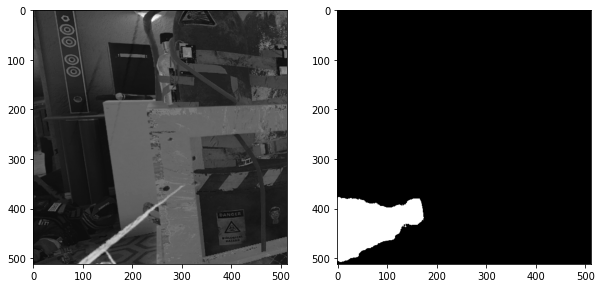

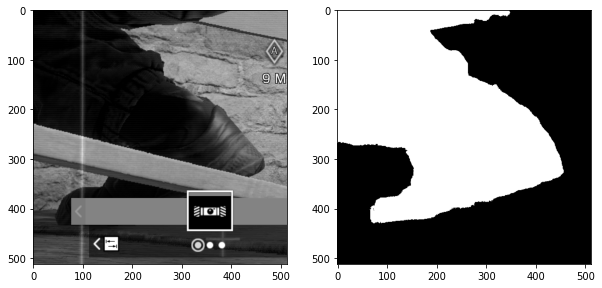

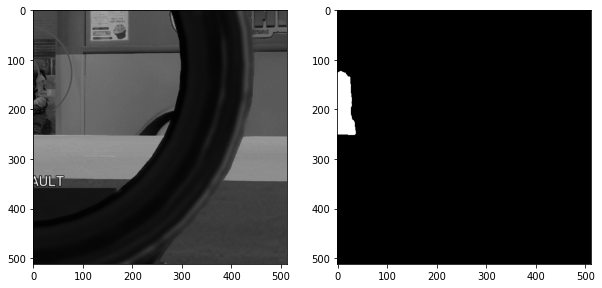

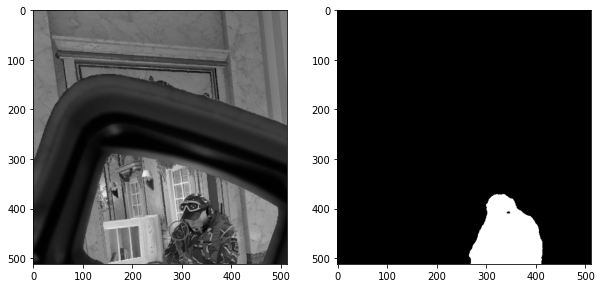

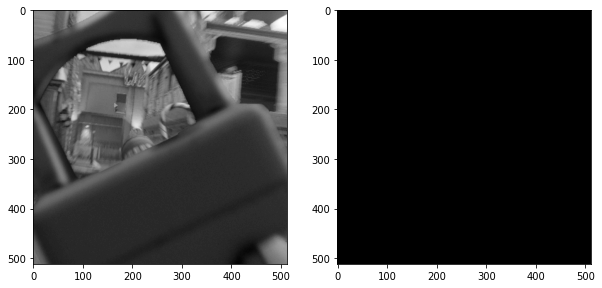

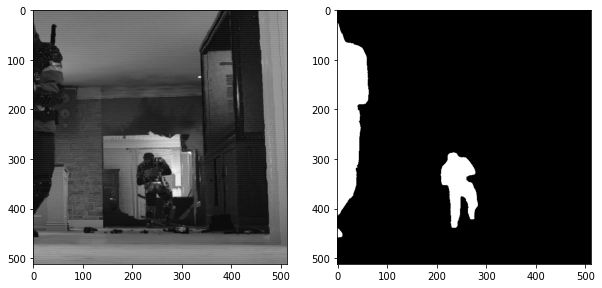

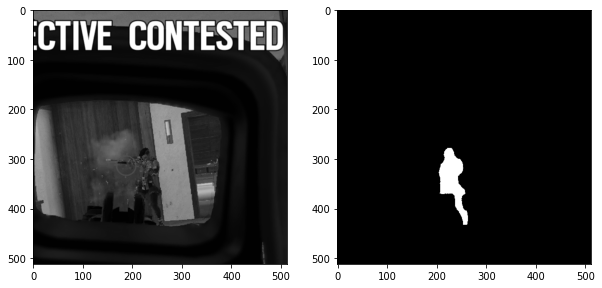

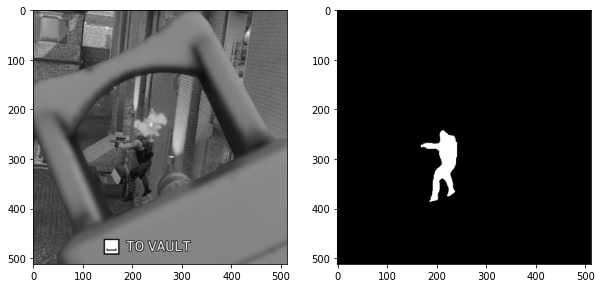

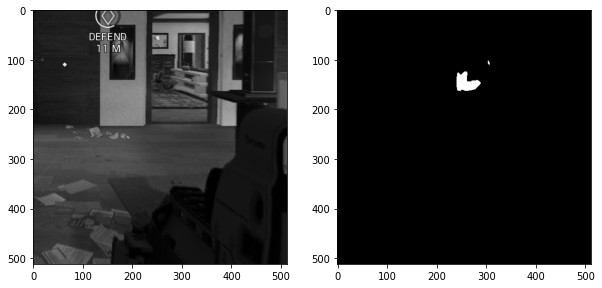

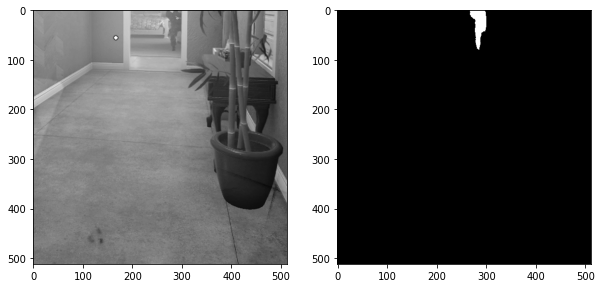

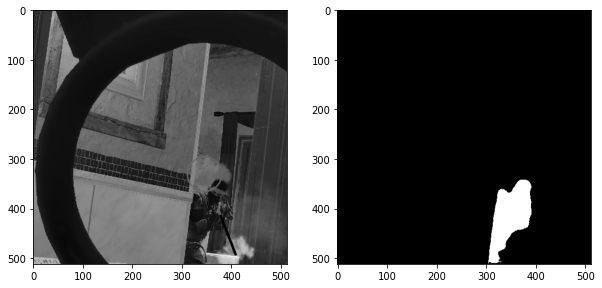

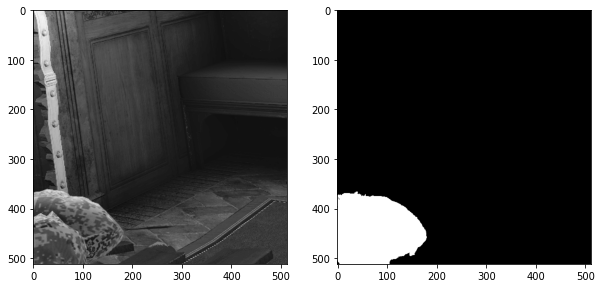

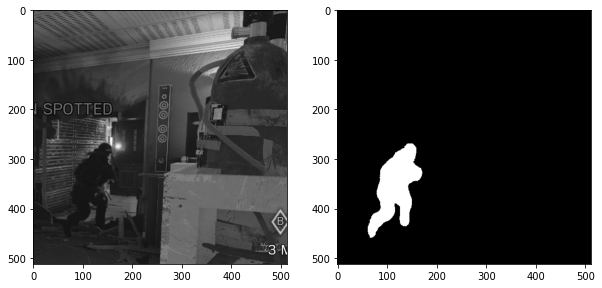

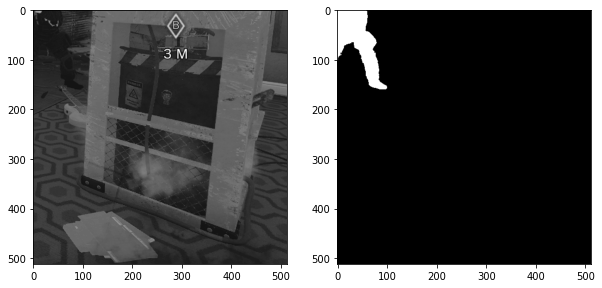

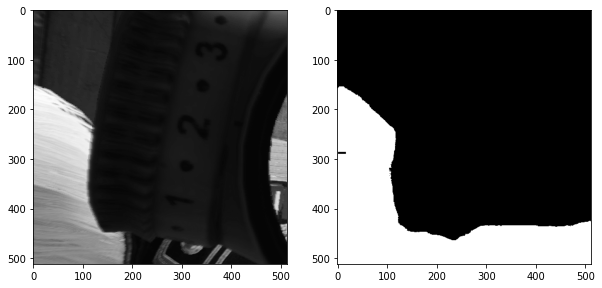

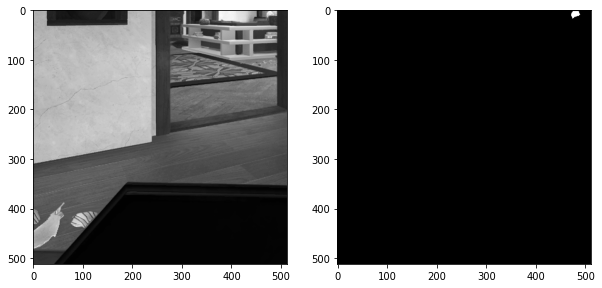

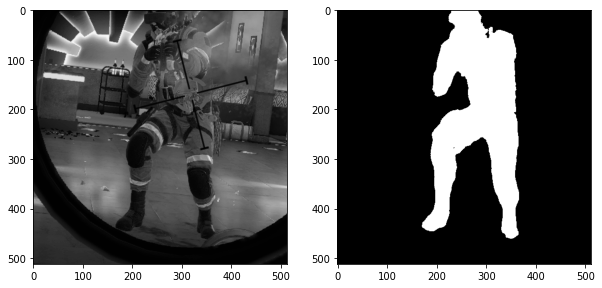

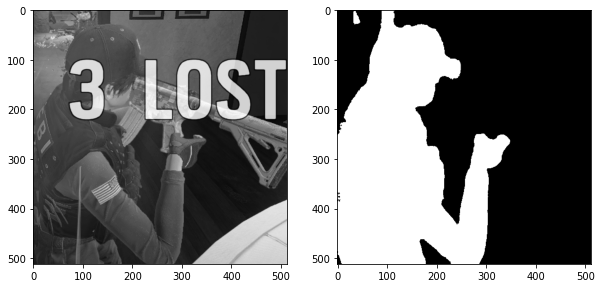

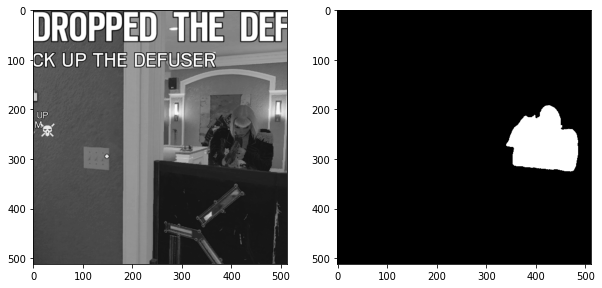

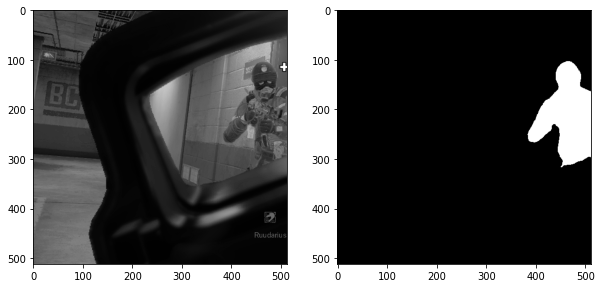

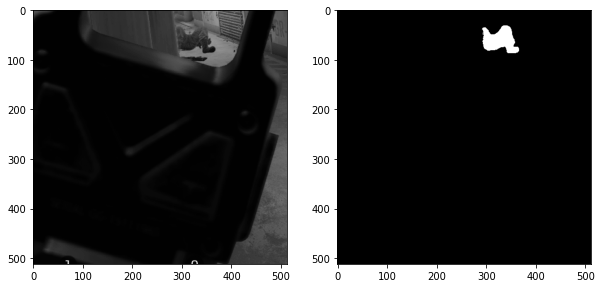

In [35]:
def ImCompareGray(Im1, Im2, FigSize=(10,10)):
    f = plt.figure(figsize=FigSize)
    f.add_subplot(1,2, 1)
    plt.imshow(Im1, cmap="gray")
    f.add_subplot(1,2, 2)
    plt.imshow(Im2, cmap="gray")
    plt.show(block=True)
Dir = r"C:\Users\8holz\Dokumente\GitHub\K14\Training_Protocol\Model-Grayscale-UNET\images.pickle"
a = pickle.load(open(Dir, "rb"))
for i in range(50):
	ImCompareGray(a[0][i], np.squeeze(a[2][i]))